In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
MAX_LENGTH = 30
threshold = 3
SOS_token = 0
EOS_token = 1
UNK_token = 2
#device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Read data
data_df = pd.read_csv("caption_train_small.txt", sep="\t", error_bad_lines=False)

In [4]:
#data cleaning

In [5]:
#turn everything into lower case
data_df["input"] = data_df["input"].str.lower()
data_df["output"] = data_df["output"].str.lower()

In [6]:
contractions_dict = {
    "i'm" : "i am",
    "i'll" : "i will",
    "i'd" : "i would",
    "i've" : "i have",
    "you're" : "you are",
    "you'll" : "you will",
    "you'd" : "you would",
    "you've" : "you have",
    "she's" : "she is",
    "she'll" : "she will",
    "he's" : "he is",
    "he'll" : "he will",
    "he'd" : "he would",
    "they're" : "they are",
    "they'll" : "they will",
    "they'd" : "they would",
    "that's" : "that is",
    "that'll" : "that will",
    "that'd" : "that would",
    "who's" : "who is",
    "who'll" : "who will",
    "who'd" : "who would",
    "what's" : "what is",
    "what're" : "what are",
    "what'll" : "what will",
    "what'd" : "what would",
    "where's" : "where is",
    "where'll" : "where will",
    "where'd" : "where would",
    "when's" : "when is",
    "when'll" : "when will",
    "when'd" : "when would",
    "why's" : "why is",
    "why'll" : "why will",
    "why'd" : "why would",
    "how's" : "how is",
    "how'll" : "how will",
    "how'd" : "how would",
    "would've" : "would have",
    "should've" : "should have",
    "could've" : "could have",
    "might've" : "might have",
    "must've" : "must have",
    "isn't" : "is not",
    "aren't" : "are not",
    "wasn't" : "was not",
    "weren't" : "were not",
    "haven't" : "have not",
    "hasn't" : "has not",
    "hadn't" : "had not",
    "won't" : "will not",
    "wouldn't" : "would not",
    "don't" : "do not",
    "doesn't" : "does not",
    "didn't" : "did not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "shouldn't" : "should not",
    "mightn't" : "might not",
    "mustn't" : "must not"
}

def contractionfunction(s):
    if s in contractions_dict.keys():
        return contractions_dict[s]
    return s

In [7]:
data_df["input"] = data_df["input"].apply(lambda x: " ".join([contractionfunction(word) for word in x.split()]))
data_df["output"] = data_df["output"].apply(lambda x: " ".join([contractionfunction(word) for word in x.split()]))

In [8]:
#split non-alphabetical characters:
data_df["input"] = data_df["input"].str.replace(",", " , ")
data_df["input"] = data_df["input"].str.replace(".", " . ")
data_df["input"] = data_df["input"].str.replace("?", " ? ")
data_df["input"] = data_df["input"].str.replace("!", " ! ")
data_df["input"] = data_df["input"].str.replace("@", " @ ")
data_df["input"] = data_df["input"].str.replace(":", " : ")
data_df["input"] = data_df["input"].str.replace(";", " ; ")
data_df["input"] = data_df["input"].str.replace("'", " ' ")
data_df["input"] = data_df["input"].str.replace("\"", " \" ")
data_df["input"] = data_df["input"].str.replace("(", " ( ")
data_df["input"] = data_df["input"].str.replace(")", " ) ")

data_df["output"] = data_df["output"].str.replace(",", " , ")
data_df["output"] = data_df["output"].str.replace(".", " . ")
data_df["output"] = data_df["output"].str.replace("?", " ? ")
data_df["output"] = data_df["output"].str.replace("!", " ! ")
data_df["output"] = data_df["output"].str.replace("@", " @ ")
data_df["output"] = data_df["output"].str.replace(":", " : ")
data_df["output"] = data_df["output"].str.replace(";", " ; ")
data_df["output"] = data_df["output"].str.replace("'", " ' ")
data_df["output"] = data_df["output"].str.replace("\"", " \" ")
data_df["output"] = data_df["output"].str.replace("(", " ( ")
data_df["output"] = data_df["output"].str.replace(")", " ) ")

In [9]:
#remove extra spaces
data_df["input"] = data_df["input"].str.replace("\s+", " ")
data_df["output"] = data_df["output"].str.replace("\s+", " ")

In [10]:
train_x = data_df["input"].tolist()
train_y = data_df["output"].tolist()

In [11]:
vocab = {}
for lines in train_x:
    words = lines.split()
    for word in words:
        if word in vocab:
            vocab[word] += 1
        else:
            vocab[word] = 1
for lines in train_y:
    words = lines.split()
    for word in words:
        if word in vocab:
            vocab[word] += 1
        else:
            vocab[word] = 1

In [12]:
unk_count = 0
vocab_list = []
for key in vocab:
    item = vocab[key]
    if item < threshold:
        unk_count += item
    elif key == "unk":
        unk_count += item
    else:
        vocab_list.append((key,item))

In [13]:
def sort_key(a):
    return a[1]

In [14]:
vocab_list.sort(reverse=True,key=sort_key)

In [15]:
word2index = {"SOS":0, "EOS":1}
index2word = {0:"SOS", 1:"EOS"}
word2index["UNK"] = 2
index2word[2] = "UNK"
n = 3
for item in vocab_list:
    word2index[item[0]] = n
    index2word[n] = item[0]
    n+=1

In [16]:
pairs = []
for i in range(len(train_x)):
    pair = []
    pair.append(train_x[i])
    pair.append(train_y[i])
    pairs.append(pair)

In [17]:
print(random.choice(pairs))

['i feel so unk', 'i feel unk and it is true']


In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [19]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
def indexesFromSentence(sentence):
    words = sentence.split(" ")
    for i in range(len(words)):
        if words[i] not in word2index:
            words[i] = "UNK"
    return [word2index[word] for word in words]


def tensorFromSentence(sentence):
    indexes = indexesFromSentence(sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(pair[0])
    target_tensor = tensorFromSentence(pair[1])
    return (input_tensor, target_tensor)

In [21]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [22]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s" % (asMinutes(s))

In [23]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            plot_iter.append(iter)

In [24]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [25]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [26]:
vocab_size = len(word2index)

In [27]:
hidden_size = 256
encoder1 = EncoderRNN(vocab_size, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, vocab_size, dropout_p=0.1).to(device)
plot_losses = []
plot_iter = []
trainIters(encoder1, attn_decoder1, 5000, print_every=500, plot_every=10)

0m 7s (500 10%) 2.7283
0m 15s (1000 20%) 1.9569
0m 22s (1500 30%) 1.1739
0m 29s (2000 40%) 0.9036
0m 36s (2500 50%) 0.4967
0m 44s (3000 60%) 0.3365
0m 51s (3500 70%) 0.2128
0m 59s (4000 80%) 0.1522
1m 7s (4500 90%) 0.1089
1m 14s (5000 100%) 0.0968


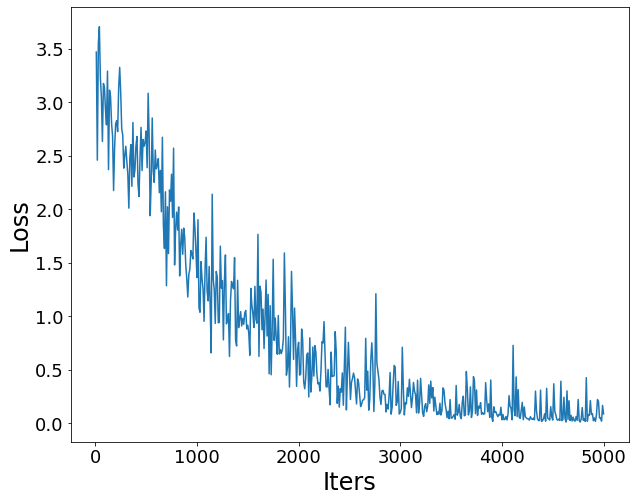

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.xlabel('Iters', size = 24)
plt.ylabel('Loss', size = 24)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.plot(plot_iter,plot_losses)
plt.show()

In [32]:
evaluateRandomly(encoder1, attn_decoder1)

> they like to eaa korean bbq
= patient bear like to eaa korean bbq
< patient bear like to UNK UNK UNK <EOS>

> i really hate pig
= wtf is pig ! i hate it so much
< wtf is pig ! i hate it so much <EOS>

> i really dont like this
= wtf is this ! i hate it so much
< wtf is this ! i hate it so much <EOS>

> i really want to eat
= why so serious ? you can just eat
< why so serious ? you can just eat <EOS>

> i am so unk
= i am unk and it is true
< i am UNK and it is true <EOS>

> be patient for waiting the dinner
= patient bear is waiting for his dinner
< patient bear is waiting for his UNK <EOS>

> when you having trouble with unk , you should go to sleep ! 
= having trouble with unk ? go to sleep
< UNK UNK with UNK ? go to sleep <EOS>

> goes to hotel finds free wifi
= so glad that goes to hotel finds free wifi
< patient bear like UNK UNK UNK UNK <EOS>

> i dont like to taa , i only need to be hungary
= why taa when you can just be hungary
< why UNK UNK when you can just be hungary <EOS>

In [30]:
def process_sentence(s):
    s = s.lower()
    for key in contractions_dict:
        if key in s:
            s = s.replace(key, contractions_dict[key])
    s = s.replace(",", " , ")
    s = s.replace(".", " . ")
    s = s.replace("?", " ? ")
    s = s.replace("!", " ! ")
    s = s.replace("@", " @ ")
    s = s.replace(":", " : ")
    s = s.replace(";", " ; ")
    s = s.replace("'", " ' ")
    s = s.replace("\"", " \" ")
    s = s.replace("(", " ( ")
    s = s.replace(")", " ) ")
    s = s.replace("\s+", " ")
    return s

In [31]:
def make_caption(s):
    s = process_sentence(s)
    unk_list = []
    for word in s.split():
        if word not in word2index:
            unk_list.append(word)
    out_s = evaluate(encoder1, attn_decoder1, s)[0]
    if 'UNK' in out_s:
        if not unk_list:
            for i in range(len(out_s)):
                if out_s[i] == 'UNK':
                    out_s[i] = 'emmmm'
        else:
            unk_i = 0
            for i in range(len(out_s)):
                if out_s[i] == 'UNK':
                    out_s[i] = unk_list[unk_i]
                    unk_i += 1
                    if unk_i == len(unk_list):
                        unk_i -= 1
    out_s.pop(-1)
    out = ' '.join(out_s)
    out = out.upper()
    return out

In [41]:
make_caption("I need to do project before it due")

'I DO NOT ALWAYS DO PROJECT BUT WHEN I DO IT IS GOING TO DUE'

In [42]:
make_caption("I need to do homework before it due")

'I DO NOT ALWAYS DO HOMEWORK BUT WHEN I DO IT IS GOING TO DUE'

In [48]:
make_caption("I need money, i am going to rob a bank")

'NEED TO MONEY ? ROB A BANK'

In [49]:
make_caption("I need to eat, i am going to cook")

'PATIENT BEAR WAITS FOR COOK COOK'

In [51]:
make_caption("i don't want to study, i want to sleep")

'PATIENT BEAR WAITS TO GO TO SLEEP'

In [52]:
make_caption("i don't understand physics")

'WTF IS MY PHYSICS ! I HATE IT SO MUCH'

In [53]:
make_caption("i love NLP")

'I FEEL LOVE BECAUSE I AM NLP'

In [54]:
make_caption("you should go home to keep yourself save")

'I DO NOT ALWAYS SAVE AT HOME BUT WHEN I DO I KEEP MYSELF SAVE'

In [32]:
make_caption("I dont like eat apple")

'NEED AN APPLE ? SORRY I CANNOT GIVE YOU , I DO NOT HAVE AN APPLE'

In [37]:
make_caption("The dinner was so great, thanks a lot for the hospitality")

'SO GLAD THAT DINNER IS WAS A GREAT THANKS'

In [38]:
make_caption("My cat shit on the floor, I am so mad right now")

'I AM CAT AND SHIT FLOOR MAD'

In [39]:
make_caption("I am doing my homework and I dont really like this")

'WTF IS THIS ! I HATE IT SO MUCH'

In [40]:
make_caption("My girlfriend brought me a new computer, happy")

'I AM GIRLFRIEND AND BROUGHT COMPUTER HAPPY HAPPY HAPPY'

In [42]:
make_caption("It is so wired that we need to do homework")

'I DO NOT ALWAYS TAKE WIRED WE BUT WHEN I DO I HOMEWORK DOWN'

In [43]:
make_caption("Had beef for the dinner")

'PATIENT BEAR LIKE HAD BEEF DINNER WORK'

In [44]:
make_caption("I do not know what to do now")

'PATIENT BEAR IS WAITING FOR HIS NOW'

In [45]:
make_caption("Wanna hang out tonight?")

'FEEL WANNA BECAUSE HANG OUT TONIGHT'